<a href="https://colab.research.google.com/github/saahilgupta93/awesome-collection-of-google-colab-notebooks/blob/master/NVidia_Tacotron2_Waveglow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-Speech with Tacotron2 and Waveglow

This is an English female voice TTS demo using open source projects [NVIDIA/tacotron2](https://github.com/NVIDIA/tacotron2) and [NVIDIA/waveglow](https://github.com/NVIDIA/waveglow).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install Tacotron2 and Waveglow

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive $git_repo_url
  #!cd $project_name && pip install -q -r requirements.txt
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

    100% |████████████████████████████████| 245kB 29.4MB/s 


## Download pretrained models

In [0]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=$file_id" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$file_id" -o $file_name

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1cjKPHbtAMh_4HTHmuIGNkbOkPBD9qwhj', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1165      0 --:--:-- --:--:-- --:--:--  1165
100  107M    0  107M    0     0  31.8M      0 --:--:--  0:00:03 --:--:-- 37.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1289      0 --:--:-- --:--:-- --:--:--  1289
100 2019M    0 2019M    0     0  50.2M      0 --:--:--  0:00:40 --:--:-- 66.3M


## Initialize Tacotron2 and Waveglow

Following code is copied from https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb and updated for the Colab.

In [0]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
model = model.cuda()
_ = model.eval()

# initialize Waveglow with the pretrained model
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow = waveglow.cuda()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'glow_old.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch

## Synthesize a text

Replace `TEXT` with your text if you want try out another text.

In [0]:
TEXT = "delhi capitals won the match today hurray!"

Now convert the text into mel spectrogram using Tacotron2 and plot it:

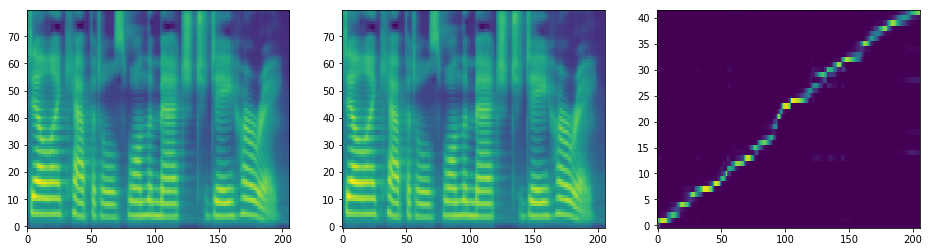

In [0]:
sequence = np.array(text_to_sequence(TEXT, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

Finally, we can convert the generated mel spectrogram into an audio:

In [0]:
audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:489: RuntimeWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  result = self.forward(*input, **kwargs)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:489: RuntimeWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  result = self.forward(*input, **kwargs)
